# Running stardate on simulated stars

Testing the code on data simulated in the Simulate_data.ipynb notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import h5py
import tqdm
import emcee

from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
mist = MIST_Isochrone()

import stardate as sd
from stardate.lhf import lnprob

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the simulated data file and plot it on an HR diagram.

In [2]:
df = pd.read_csv("data/simulated_data.csv")

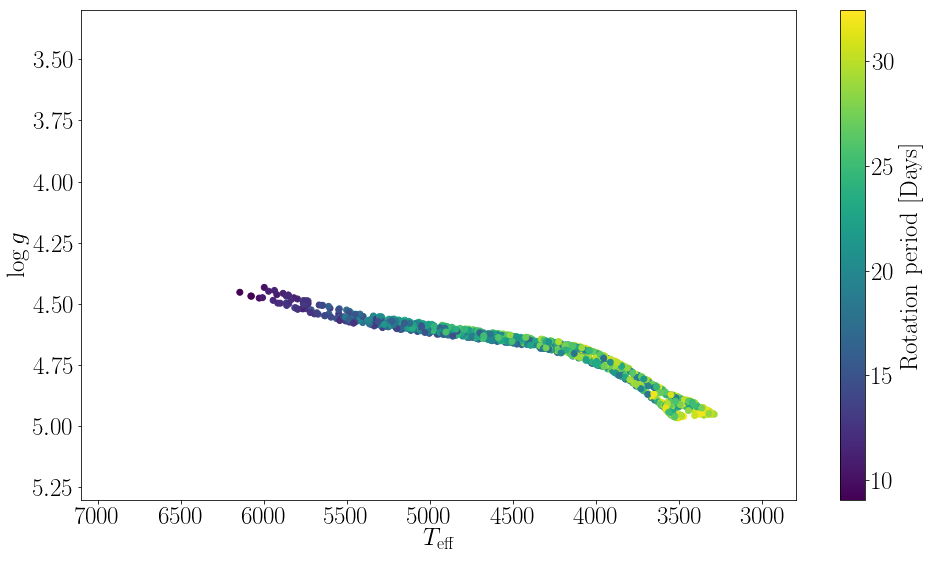

In [3]:
plt.figure(figsize=(16, 9))
plt.scatter(df.teff, df.logg, c=df.prot)
plt.ylim(5.3, 3.3)
plt.xlim(7100, 2800)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log g$")
plt.colorbar(label="$\mathrm{Rotation~period~[Days]}$")

Small observational uncertainties are needed (even though the stars weren't simulated with any) in order to get a good fit.

In [4]:
teff_err = 25  # Kelvin
logg_err = .05  # dex
feh_err = .05  # dex
jmag_err = .01 # mags
hmag_err = .01  # mags
kmag_err = .01  # mags
parallax_err = .05  # milliarcseconds
prot_err = 1  # Days
BV_err = .01  # mags

# Recover stellar parameters of simulated stars

Test the likelihood function.

In [5]:
i = 0
iso_params = pd.DataFrame(dict({"teff": (df.teff[i], teff_err),
                                "logg": (df.logg[i], logg_err),
                                "feh": (df.feh[i], feh_err), 
                                "jmag": (df.jmag[i], jmag_err),
                                "hmag": (df.hmag[i], hmag_err),
                                "kmag": (df.kmag[i], kmag_err),
                                "parallax": (df.parallax[i], parallax_err)}))

mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, df.prot[i], 1, False, True]  # the lnprob arguments]

lnparams = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
            np.log(df.d_kpc.values[i]*1e3) + .2, df.Av.values[i]]
bad_lnprob = lnprob(lnparams, *args)
print(bad_lnprob)

lnparams = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
            np.log(df.d_kpc.values[i]*1e3), df.Av.values[i]]
good_lnprob = lnprob(lnparams, *args)
print(good_lnprob)

assert bad_lnprob[0] < good_lnprob[0], "True parameters values must give a higher likelihood than wrong values"

(-38.60372041606223, -24.221837503676667)
(-24.621837503676666, -24.621837503676666)


In [ ]:
def gyro_age(period, bv):
    a, b, c, n = [.4, .31, .45, .55]
    return np.log10(((period/(a*(bv-c)**b))**(1./n))*1e6)

def test_gyro_is_on(bv, eep, age, feh, prot):
    if bv < .45:
        print("too hot")
        return False, (10**gyro_age(prot, bv))*1e-9
    if eep > 454:
        print("Evolved")
        return False, (10**gyro_age(prot, bv))*1e-9
    else:
        print("Suitable for gyro")
        return True, (10**gyro_age(prot, bv))*1e-9

Infer ages of the simulated stars. WARNING: this will take a long time to run!

In [ ]:
# The directory where the posterior samples and result plots will be saved.
savedir = "simulation_results/iso_and_gyro"
savedir_iso = "simulation_results/iso_only"

N = len(df)
for i in range(N):
    print(i, "of", N)
    
    status, gage = test_gyro_is_on(df.B[i] - df.V[i], df.eep[i], df.age[i], df.feh[i], df.prot[i])
    print("gyro age = ", gage, "\n")

    # Set up the parameter dictionary. 
    iso_params = {"teff": (df.teff[i], teff_err),
                  "logg": (df.logg[i], logg_err),
                  "feh": (df.feh[i], feh_err), 
                  "jmag": (df.jmag[i], jmag_err),
                  "hmag": (df.hmag[i], hmag_err),
                  "kmag": (df.kmag[i], kmag_err),
                  "parallax": (df.parallax[i], parallax_err)}
    
    # Infer an age with isochrones and gyrochronology.
    
    # Set up the star object
    star = sd.star(iso_params, df.prot[i], .01, savedir=savedir, suffix=i)
    
    # Run the MCMC
    sampler = star.fit(max_n=200000, rossby=True)

    # Plot the chains and make a corner plot
    # Mass [M_sun], Age [log10(yrs)], [Fe/H] [dex], Distance [ln(pc)], A_v [R: 0-1]
    truths = [df.mass.values[i], df.eep.values[i], df.age.values[i], df.feh.values[i], 
              np.log(df.d_kpc.values[i]*1e3), df.Av.values[i]]
    star.make_plots(truths, burnin=100)
    
    # Now infer an age with isochrones only.
    
    # Set up the star object
    star_iso = sd.star(iso_params, df.prot[i], .01, savedir=savedir_iso, suffix=i)
    
    # Run the MCMC
    sampler = star_iso.fit(max_n=200000, iso_only=True, rossby=True)
    
    # Plot the chains and make a corner plot
    truths = [df.mass.values[i], df.eep.values[i], df.age.values[i], df.feh.values[i], 
              df.d_kpc.values[i]*1e3, df.Av.values[i]]
    star_iso.make_plots(truths, burnin=100)

  0%|          | 0/200000 [00:00<?, ?it/s]

0 of 1000
Suitable for gyro
gyro age =  1.370265857677247 



  0%|          | 89/200000 [00:00<23:39, 140.83it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 185/200000 [00:01<20:54, 159.25it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:43: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
  5

nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 91/200000 [00:01<1:12:38, 45.87it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 290/200000 [00:02<17:46, 187.30it/s] /Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in true_divide
  c

nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 19/200000 [00:00<18:17, 182.27it/s]

1 of 1000
Suitable for gyro
gyro age =  2.0838018947567076 



  0%|          | 100/200000 [00:00<17:35, 189.32it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 287/200000 [00:01<18:34, 179.23it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in true_divide
  co

nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 91/200000 [00:00<15:03, 221.23it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 294/200000 [00:01<14:39, 226.97it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in true_divide
  con

nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 20/200000 [00:00<17:05, 194.96it/s]

2 of 1000
Suitable for gyro
gyro age =  2.7458916717528123 



  0%|          | 100/200000 [00:00<17:11, 193.74it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 300/200000 [00:01<17:05, 194.72it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in true_divide
  co

nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 81/200000 [00:00<16:52, 197.37it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
100%|██████████| 200000/200000 [14:26<00:00, 230.80it/s]


nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 20/200000 [00:00<17:24, 191.47it/s]

3 of 1000
Suitable for gyro
gyro age =  2.4644497728191257 



  0%|          | 100/200000 [00:00<17:15, 193.03it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 296/200000 [00:01<17:15, 192.89it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in true_divide
  co

nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 90/200000 [00:00<15:20, 217.25it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 295/200000 [00:01<14:37, 227.48it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in true_divide
  con

nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 40/200000 [00:00<16:52, 197.40it/s]

4 of 1000
Suitable for gyro
gyro age =  2.6131222957229046 



  0%|          | 100/200000 [00:00<17:33, 189.78it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 197/200000 [00:01<17:13, 193.28it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:43: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
  

nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 85/200000 [00:00<16:17, 204.50it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 283/200000 [00:01<15:32, 214.13it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in true_divide
  con

nsteps =  2000 burnin =  100
Plotting age posterior
Plotting production chains...
Making corner plot...


  0%|          | 16/200000 [00:00<21:05, 158.00it/s]

5 of 1000
Suitable for gyro
gyro age =  2.3175667334214354 



  0%|          | 90/200000 [00:00<19:05, 174.54it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:101: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:246: RuntimeWarning: invalid value encountered in less
  converged = np.all(tau * 100 < sampler.iteration)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:247: RuntimeWarning: invalid value encountered in less
  converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
  0%|          | 188/200000 [00:01<27:12, 122.38it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/autocorr.py:43: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
 94